In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

In [118]:
polymer="PTZMA"
solution="EC_DMC_LiPF6"
percent="20_Percent"

name=f"{polymer}-{solution}"
print(name)
data_path=f"/Volumes/project/depablo/mleyf3/DMREF/{name}/{percent}_0_SoC"

if polymer == "PVMPT":
    data_path=f"/Volumes/project/depablo/mleyf3/DMREF/PVMPT_Simulations/{name}/{percent}_0_SoC"

if percent == "0_Percent":
    data_path=f"/Volumes/project/depablo/mleyf3/DMREF/{polymer}/{polymer}_n30"

print(data_path)

PTZMA-EC_DMC_LiPF6
/Volumes/project/depablo/mleyf3/DMREF/PTZMA-EC_DMC_LiPF6/20_Percent_0_SoC


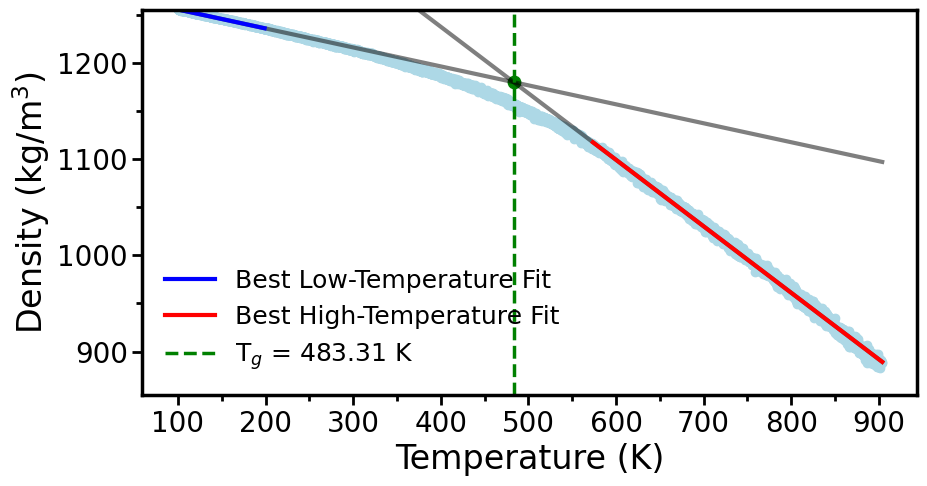

20_Percent PTZMA EC_DMC_LiPF6, snapshot 150 ns


In [119]:
timing=150

density = np.genfromtxt([i for i in open(f'{data_path}/cool/density_cool_from_{timing}ns.xvg').read().splitlines() if not i.startswith(('#','@'))])
temperature = np.genfromtxt([i for i in open(f'{data_path}/cool/temperature_cool_from_{timing}ns.xvg').read().splitlines() if not i.startswith(('#','@'))])

time = temperature.T[0][500:]
density = density.T[1][500:]  # Eliminates first 5.03 ns
temperature = temperature.T[1][500:]  # Eliminates first 5.03 ns

# Define the linear function with a constraint that it passes through a specified point
def constrained_linear(x, m, x0, y0):
    b = y0 - m * x0  # Calculate intercept to force the line through the specified point
    return m * x + b

# Function to calculate R²
def calculate_r2(x, y, m, x0, y0):
    y_pred = constrained_linear(x, m, x0, y0)
    return r2_score(y, y_pred)

# Function to fit a line with the constraint and return the slope and R²
def fit_constrained_line(x, y, x0, y0):
    m = np.polyfit(x - x0, y - y0, 1)[0]  # Fit line with the constraint
    r2 = calculate_r2(x, y, m, x0, y0)
    return m, r2

########################### LOW TEMPERATURE ###########################
# Initialize variables to store the best fit
best_r2 = -np.inf
best_params = None
best_start_index = None

# Define chunk size
chunk_size = 5
#print(f"Low chunk size = {chunk_size}")

# Iterate through chunks of data ending at the last point
for start_index in range(len(temperature) - 100, -1, -chunk_size):
    temp_chunk = temperature[start_index:]
    dens_chunk = density[start_index:]

    m, r2 = fit_constrained_line(temp_chunk, dens_chunk, temperature[-1], density[-1])

    if r2 > best_r2:
        best_r2 = r2
        best_params = m
        best_start_index = start_index

# Get the final intercept for the best fit
LowTemp_m = best_params
LowTemp_b = density[-1] - LowTemp_m * temperature[-1]
LowTemp_best_r2 = best_r2
LowTemp_best_start_index = best_start_index


# Plot the data and the best fit
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(temperature, density, color='lightblue')

ax.plot(temperature[:], constrained_linear(temperature[:], LowTemp_m, temperature[-1], density[-1]), color='k', lw = 3, alpha = 0.5)
ax.plot(temperature[best_start_index:], constrained_linear(temperature[best_start_index:], LowTemp_m, temperature[-1], density[-1]), lw = 3, label='Best Low-Temperature Fit', color='blue')

########################### HIGH TEMPERATURE ###########################
# Sort data in descending order by temperature
sorted_indices = np.argsort(-temperature)
temperature = temperature[sorted_indices]
density = density[sorted_indices]

# Initialize variables to store the best fit
best_r2 = -np.inf
best_params = None
best_end_index = None

# Define initial start index and chunk size
initial_end_index = 100
chunk_size = 5
#print(f"High chunk size = {chunk_size}")

# Iterate through chunks of data starting from the highest temperature
for end_index in range(initial_end_index, len(temperature) + 1, chunk_size):
    temp_chunk = temperature[:end_index]
    dens_chunk = density[:end_index]

    m, r2 = fit_constrained_line(temp_chunk, dens_chunk, temperature[0], density[0])

    if r2 > best_r2:
        best_r2 = r2
        best_params = m
        best_end_index = end_index
        #best_end_index = 2000

# Get the final intercept for the best fit
HighTemp_m = best_params
HighTemp_b = density[0] - HighTemp_m * temperature[0]
HighTemp_best_r2 = best_r2
HighTemp_best_end_index = best_end_index

ax.plot(temperature[:], constrained_linear(temperature[:], HighTemp_m, temperature[0], density[0]), color='k', lw = 3, alpha=0.5)
ax.plot(temperature[:HighTemp_best_end_index], constrained_linear(temperature[:HighTemp_best_end_index], HighTemp_m, temperature[0], density[0]), lw = 3, label='Best High-Temperature Fit', color='red')

########################### INTERSECTION ###########################
# Calculate the intersection point
T_intersect = (HighTemp_b - LowTemp_b) / (LowTemp_m - HighTemp_m)
D_intersect = LowTemp_m * T_intersect + LowTemp_b

ax.axvline(x=T_intersect, color='green', linestyle='--', lw=2.5, label=f'T$_g$ = {T_intersect:.2f} K')
ax.scatter(T_intersect, D_intersect, color='green', s= 80 )

#########################################################################
ax.set_xlabel('Temperature (K)',  fontsize=24)
ax.set_ylabel('Density (kg/m$^3$)',  fontsize=24)
ax.set_ylim(855, 1255)
#ax.set_title(f"Snapshot from t= {timing}ns",  fontsize=22, pad=10 )

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(50))

ax.tick_params(axis='both', width=2.0, length=7, labelsize=20)
ax.tick_params(axis='both', which='minor', width=2.0, length=4)

plt.legend(fontsize=18, frameon=False)

#plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/DMREF/Tg_calculation.png', bbox_inches='tight', dpi=300)

plt.show()

# Output the fit parameters and the best start index
#print(f"Best Low-Temperature Fit Parameters: m = {LowTemp_m}, b = {LowTemp_b}, R² = {LowTemp_best_r2}")
#print(f"Best Low-Temperature Start Index: {LowTemp_best_start_index}")


# Output the fit parameters and the best end index
#print(f"Best High-Temperature Fit Parameters: m = {HighTemp_m}, b = {HighTemp_b}, R² = {HighTemp_best_r2}")
#print(f"Best High-Temperature End Index: {HighTemp_best_end_index}")

print(f"{percent} {polymer} {solution}, snapshot {timing} ns")


Average glass transition temperature = 484.35 K
Error bar (standard deviation) = 1.68 K


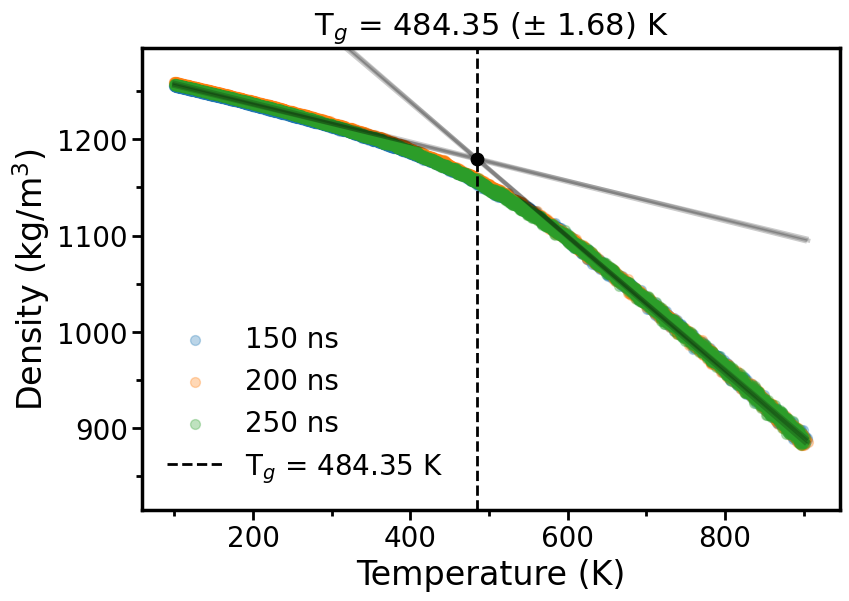

20_Percent PTZMA EC_DMC_LiPF6


In [122]:
timings = [150, 200, 250]
Tg_values = []
D_values = []

fig, ax = plt.subplots(figsize=(9, 6))

# Define the linear function with a constraint that it passes through a specified point
def constrained_linear(x, m, x0, y0):
    b = y0 - m * x0  # Calculate intercept to force the line through the specified point
    return m * x + b

# Function to calculate R²
def calculate_r2(x, y, m, x0, y0):
    y_pred = constrained_linear(x, m, x0, y0)
    return r2_score(y, y_pred)

# Function to fit a line with the constraint and return the slope and R²
def fit_constrained_line(x, y, x0, y0):
    m = np.polyfit(x - x0, y - y0, 1)[0]  # Fit line with the constraint
    r2 = calculate_r2(x, y, m, x0, y0)
    return m, r2

for timing in timings:
    density = np.genfromtxt([i for i in open(f'{data_path}/cool/density_cool_from_{timing}ns.xvg').read().splitlines() if not i.startswith(('#','@'))])
    temperature = np.genfromtxt([i for i in open(f'{data_path}/cool/temperature_cool_from_{timing}ns.xvg').read().splitlines() if not i.startswith(('#','@'))])
    
    time = temperature.T[0][500:]
    density = density.T[1][500:]  # Eliminates first 5.03 ns
    temperature = temperature.T[1][500:]  # Eliminates first 5.03 ns



    ########################### LOW TEMPERATURE ###########################
    # Initialize variables to store the best fit
    best_r2 = -np.inf
    best_params = None
    best_start_index = None
    
    # Define chunk size
    chunk_size = 5
    #print(f"Low chunk size = {chunk_size}")
    
    # Iterate through chunks of data ending at the last point
    for start_index in range(len(temperature) - 100, -1, -chunk_size):
        temp_chunk = temperature[start_index:]
        dens_chunk = density[start_index:]
    
        m, r2 = fit_constrained_line(temp_chunk, dens_chunk, temperature[-1], density[-1])
    
        if r2 > best_r2:
            best_r2 = r2
            best_params = m
            best_start_index = start_index
    
    # Get the final intercept for the best fit
    LowTemp_m = best_params
    LowTemp_b = density[-1] - LowTemp_m * temperature[-1]
    LowTemp_best_r2 = best_r2
    LowTemp_best_start_index = best_start_index

    ########################### HIGH TEMPERATURE ###########################
    # Sort data in descending order by temperature
    sorted_indices = np.argsort(-temperature)
    temperature = temperature[sorted_indices]
    density = density[sorted_indices]
    
    # Initialize variables to store the best fit
    best_r2 = -np.inf
    best_params = None
    best_end_index = None
    
    # Define initial start index and chunk size
    initial_end_index = 100
    chunk_size = 5
    #print(f"High chunk size = {chunk_size}")
    
    # Iterate through chunks of data starting from the highest temperature
    for end_index in range(initial_end_index, len(temperature) + 1, chunk_size):
        temp_chunk = temperature[:end_index]
        dens_chunk = density[:end_index]
    
        m, r2 = fit_constrained_line(temp_chunk, dens_chunk, temperature[0], density[0])
    
        if r2 > best_r2:
            best_r2 = r2
            best_params = m
            best_end_index = end_index
            #best_end_index = 2000
    
    # Get the final intercept for the best fit
    HighTemp_m = best_params
    HighTemp_b = density[0] - HighTemp_m * temperature[0]
    HighTemp_best_r2 = best_r2
    HighTemp_best_end_index = best_end_index

    ########################### INTERSECTION ###########################
    # Calculate the intersection point
    T_intersect = (HighTemp_b - LowTemp_b) / (LowTemp_m - HighTemp_m)
    D_intersect = LowTemp_m * T_intersect + LowTemp_b

    Tg_values.append(T_intersect)
    D_values.append(D_intersect)

    ###################### PLOTTING ###########################
    ax.scatter(temperature, density, label=f"{timing} ns",
              alpha = 0.3, s = 50)
    ax.plot(temperature[:], constrained_linear(temperature[:], LowTemp_m, temperature[-1], density[-1]), color='k', lw = 3, alpha = 0.2)
    ax.plot(temperature[:], constrained_linear(temperature[:], HighTemp_m, temperature[0], density[0]), color='k', lw = 3, alpha=0.2)


# After all three runs, compute the mean and std
mean_Tg = np.mean(Tg_values)
std_Tg = np.std(Tg_values)
mean_D = np.mean(D_values)


print(f"Average glass transition temperature = {mean_Tg:.2f} K")
print(f"Error bar (standard deviation) = {std_Tg:.2f} K")

# Plot avg Tg
ax.axvline(x=mean_Tg, color='k', linestyle='--', lw=2, label=f'T$_g$ = {mean_Tg:.2f} K')
ax.scatter(mean_Tg, mean_D, color='k', s= 80 )

#########################################################################
ax.set_xlabel('Temperature (K)',  fontsize=24)
ax.set_ylabel('Density (kg/m$^3$)',  fontsize=24)
ax.set_ylim(815, 1295)
ax.set_title(f"T$_g$ = {mean_Tg:.2f} (± {std_Tg:.2f}) K", fontsize = 22, pad=10)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.xaxis.set_minor_locator(MultipleLocator(100))

ax.tick_params(axis='both', width=2.0, length=7, labelsize=20)
ax.tick_params(axis='both', which='minor', width=2.0, length=4)

plt.legend(fontsize=20, frameon=False)

plt.savefig(f'/Users/mleyf/Documents/DMREF/Backbone study/Figures/{polymer}/Tg_{percent}.png', bbox_inches='tight', dpi=300)

plt.show()

print(f"{percent} {polymer} {solution}")


In [123]:
    #   'comp(%)', 'Polymer', 'Tg_avg','Tg_err',
data = [[        0,   'PhPTZ',   642.48,   22.61,],
        [        5,   'PhPTZ',   577.22,    6.29,],
        [       10,   'PhPTZ',   539.50,    7.78,],
        [       20,   'PhPTZ',   497.61,    4.27,],
        [        0,   'PVMPT',   601.56,    4.62,],
        [        5,   'PVMPT',   579.55,    9.45,],
        [       10,   'PVMPT',   538.37,    1.95,],
        [       20,   'PVMPT',   512.00,    3.99,],
        [        0,   'PTZMA',   578.30,    7.26,],
        [        5,   'PTZMA',   547.34,    6.76,],
        [       10,   'PTZMA',   509.88,   14.16,],
        [       20,   'PTZMA',   484.35,    1.68,],
        [        0,   'PVBPT',   633.63,   10.90,],
        [        5,   'PVBPT',   582.42,   13.51,],
        [       10,   'PVBPT',   536.22,    7.41,],
        [       20,   'PVBPT',   497.74,    7.50,],
        [        0,   'PVPPP',   559.01,   10.78,],
        [        5,   'PVPPP',   521.68,    4.11,],
        [       10,   'PVPPP',   503.70,    1.08,],
        [       20,   'PVPPP',   475.05,    9.59,],
        [        0,   'PEOPTZ',  540.92,    5.85,],
        [        5,   'PEOPTZ',  np.nan,  np.nan,],
        [       10,   'PEOPTZ',  np.nan,  np.nan,],
        [       20,   'PEOPTZ',  np.nan,  np.nan,],
]

df = pd.DataFrame(data, columns=['comp(%)', 'Polymer', 'Tg_avg','Tg_err'])
df

,comp(%),Polymer,Tg_avg,Tg_err
0,0,PhPTZ,642.48,22.61
1,5,PhPTZ,577.22,6.29
2,10,PhPTZ,539.50,7.78
3,20,PhPTZ,497.61,4.27
4,0,PVMPT,601.56,4.62
5,5,PVMPT,579.55,9.45
6,10,PVMPT,538.37,1.95
7,20,PVMPT,512.00,3.99
8,0,PTZMA,578.30,7.26
9,5,PTZMA,547.34,6.76


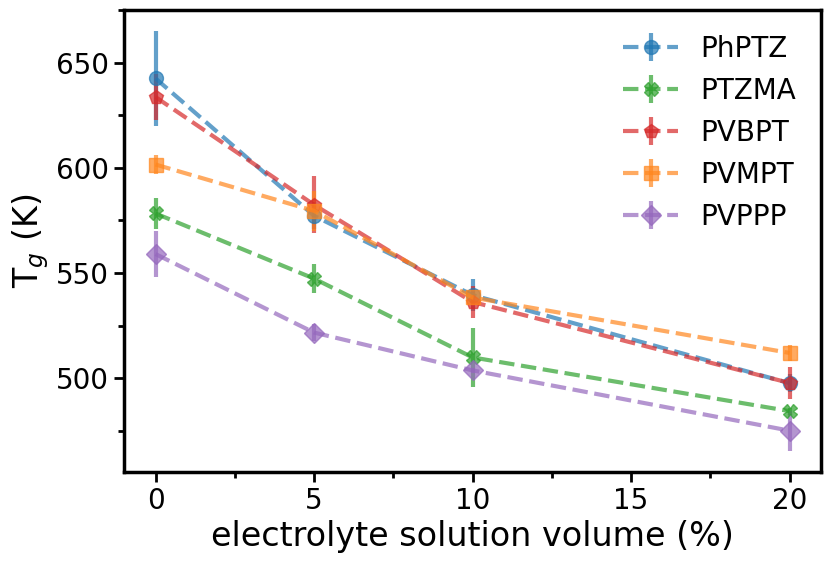

In [125]:
fig, ax = plt.subplots(figsize=(9, 6))

orange = '#FF871E'
blue = '#2178B4'
green = '#2EA12E'
purple = '#9568BD'
red = '#D6292A'

ax.errorbar(df[df["Polymer"]=="PhPTZ"]["comp(%)"],
             df[df["Polymer"]=="PhPTZ"]["Tg_avg"],
             df[df["Polymer"]=="PhPTZ"]["Tg_err"],
             marker="o", alpha=0.7, color=blue,lw=3, ms=10,ls="--",
             label="PhPTZ")

ax.errorbar(df[df["Polymer"]=="PTZMA"]["comp(%)"],
             df[df["Polymer"]=="PTZMA"]["Tg_avg"],
             df[df["Polymer"]=="PTZMA"]["Tg_err"],
             marker="X", alpha=0.7, color=green,lw=3,ms=10,ls="--",
             label="PTZMA")

ax.errorbar(df[df["Polymer"]=="PVBPT"]["comp(%)"],
             df[df["Polymer"]=="PVBPT"]["Tg_avg"],
             df[df["Polymer"]=="PVBPT"]["Tg_err"],
             marker="p", alpha=0.7, color=red, lw=3, ms = 10, ls="--",
             label="PVBPT")


ax.errorbar(df[df["Polymer"]=="PVMPT"]["comp(%)"],
             df[df["Polymer"]=="PVMPT"]["Tg_avg"],
             df[df["Polymer"]=="PVMPT"]["Tg_err"],
             marker="s", alpha=0.7, color=orange,lw=3, ms=10,ls="--",
             label="PVMPT")

ax.errorbar(df[df["Polymer"]=="PVPPP"]["comp(%)"],
             df[df["Polymer"]=="PVPPP"]["Tg_avg"],
             df[df["Polymer"]=="PVPPP"]["Tg_err"],
             marker="D", alpha=0.7, color=purple,lw=3, ms=10,ls="--",
             label="PVPPP")

ax.legend(fontsize=20, frameon=False)
ax.set_xlabel("electrolyte solution volume (%)", fontsize=24)
ax.set_ylabel(r"T$_g$ (K)", fontsize=24)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)  # Makes the border thicker

ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(25))  # Minor ticks every 10 units

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))  # Minor ticks every 5 units

ax.tick_params(axis='both', width=2.0, length=7, labelsize=20)
ax.tick_params(axis='both', which='minor', width=2.0, length=4)

plt.savefig(f'/Users/mleyf/Documents/DMREF/Backbone study/Figures/Tg_summary_{temp}.png', bbox_inches='tight', dpi=300)
